In [1]:
import warnings
import sys
from pyscf import data

warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import h5py
from atom_rdf_pack.atom_rdf import get_rmsd_error, rad
from matplotlib import pyplot as plt

In [3]:
atom_config = ["B+1", "B+3", "C+2", "C+4", "N+3", "N+5", "O+4", "O+6", "F+5", "F+7", "Ne+0", "Ne+6", "Ne+8"]
atom_config_with_be = atom_config + ["Be+0"]

In [4]:
atom_cfg = [(l, l.split("+")[0], int(l.split("+")[1])) for l in atom_config]
atom_cfg_with_be = [(l, l.split("+")[0], int(l.split("+")[1])) for l in atom_config_with_be]

In [5]:
def h5group_to_dict(grp):
    dct = {}
    for key, val in grp.items():
        if isinstance(val, h5py.Dataset):
            dct[key] = val[()]
        else:
            dct[key] = h5group_to_dict(val)
    return dct

In [6]:
def get_rdf_error(dct1, dct2):
    return pd.Series({key: get_rmsd_error(dct1[key], dct2[key], scale=key) for key in ["RHO", "GRD", "LR"]}) / data.nist.BOHR

In [7]:
basis_pvxz = ["aug-cc-pvdz", "aug-cc-pvtz", "aug-cc-pvqz", "aug-cc-pv5z"]
basis_pwcvxz = ["aug-cc-pwcvdz", "aug-cc-pwcvtz", "aug-cc-pwcvqz", "aug-cc-pwcv5z"]

# Density Part

In [8]:
%%time
with h5py.File("rdf.h5", "r") as f:
    rdf_dict = h5group_to_dict(f)

CPU times: user 370 ms, sys: 338 ms, total: 709 ms
Wall time: 1.56 s


In [9]:
%%time
with h5py.File("rdf-ri.h5", "r") as f:
    rdf_ri_dict = h5group_to_dict(f)

CPU times: user 146 ms, sys: 130 ms, total: 276 ms
Wall time: 605 ms


## HF

In [10]:
dct_ri = {}
for atom in atom_config:
    dct_ri[atom] = {}
    for basis in basis_pvxz:
        err = get_rdf_error(rdf_ri_dict['HF-RI'][basis][atom], rdf_dict['HF'][basis][atom])
        for task in ["RHO", "GRD", "LR"]:
            dct_ri[atom][(basis, task)] = err[task]

In [11]:
tab_mean = pd.DataFrame.from_dict(dct_ri).T.mean()
tab_mean = pd.DataFrame({basis: tab_mean[basis] for basis in basis_pvxz}).T
tab_hf_pre_mean = tab_mean
tab_mean.style.format("{:.2E}")

,RHO,GRD,LR
aug-cc-pvdz,1.48E-04,6.81E-05,2.32E-05
aug-cc-pvtz,1.46E-04,8.61E-05,4.69E-05
aug-cc-pvqz,1.92E-04,1.09E-04,5.87E-05
aug-cc-pv5z,2.30E-04,1.31E-04,6.82E-05


In [12]:
tab_max = pd.DataFrame.from_dict(dct_ri).T.max()
tab_max = pd.DataFrame({basis: tab_max[basis] for basis in basis_pvxz}).T
tab_hf_pre_max = tab_max
tab_max.style.format("{:.2E}")

,RHO,GRD,LR
aug-cc-pvdz,1.28E-03,5.51E-04,1.45E-04
aug-cc-pvtz,9.45E-04,3.92E-04,1.52E-04
aug-cc-pvqz,6.04E-04,4.06E-04,2.50E-04
aug-cc-pv5z,1.40E-03,7.45E-04,3.04E-04


In [13]:
dct_etb = {}
for atom in atom_config:
    dct_etb[atom] = {}
    for basis in basis_pvxz + basis_pwcvxz:
        err = get_rdf_error(rdf_ri_dict['HF-ETB'][basis][atom], rdf_dict['HF'][basis][atom])
        for task in ["RHO", "GRD", "LR"]:
            dct_etb[atom][(basis, task)] = err[task]

In [14]:
tab_mean = pd.DataFrame.from_dict(dct_etb).T.mean()
tab_mean = pd.DataFrame({basis: tab_mean[basis] for basis in basis_pvxz + basis_pwcvxz}).T
tab_hf_etb_mean = tab_mean
tab_mean.style.format("{:.2E}")

,RHO,GRD,LR
aug-cc-pvdz,3.18E-05,1.36E-05,3.88E-06
aug-cc-pvtz,1.32E-05,5.51E-06,2.58E-06
aug-cc-pvqz,5.74E-06,3.93E-06,2.24E-06
aug-cc-pv5z,2.94E-06,1.65E-06,9.00E-07
aug-cc-pwcvdz,3.43E-05,1.67E-05,6.96E-06
aug-cc-pwcvtz,1.47E-05,8.75E-06,8.05E-06
aug-cc-pwcvqz,1.07E-05,9.34E-06,9.62E-06
aug-cc-pwcv5z,6.03E-06,5.49E-06,8.52E-06


In [15]:
tab_max = pd.DataFrame.from_dict(dct_etb).T.max()
tab_max = pd.DataFrame({basis: tab_max[basis] for basis in basis_pvxz + basis_pwcvxz}).T
tab_hf_etb_max = tab_max
tab_max.style.format("{:.2E}")

,RHO,GRD,LR
aug-cc-pvdz,3.28E-04,1.42E-04,3.67E-05
aug-cc-pvtz,1.59E-04,6.14E-05,2.68E-05
aug-cc-pvqz,4.65E-05,2.61E-05,1.17E-05
aug-cc-pv5z,1.11E-05,5.56E-06,2.78E-06
aug-cc-pwcvdz,3.46E-04,1.51E-04,4.42E-05
aug-cc-pwcvtz,1.43E-04,7.08E-05,6.48E-05
aug-cc-pwcvqz,9.34E-05,7.45E-05,5.69E-05
aug-cc-pwcv5z,2.05E-05,1.71E-05,2.57E-05


## MP2

In [16]:
dct_ri = {}
for atom in atom_config:
    dct_ri[atom] = {}
    for basis in basis_pvxz + basis_pwcvxz:
        err = get_rdf_error(rdf_ri_dict['MP2-RI'][basis][atom], rdf_dict['MP2'][basis][atom])
        for task in ["RHO", "GRD", "LR"]:
            dct_ri[atom][(basis, task)] = err[task]

In [17]:
tab_mean = pd.DataFrame.from_dict(dct_ri).T.mean()
tab_mean = pd.DataFrame({basis: tab_mean[basis] for basis in basis_pvxz + basis_pwcvxz}).T
tab_mp2_pre_mean = tab_mean
tab_mean.style.format("{:.2E}")

,RHO,GRD,LR
aug-cc-pvdz,2.37E-04,5.99E-02,7.34E-03
aug-cc-pvtz,1.50E-04,1.33E-01,3.52E-02
aug-cc-pvqz,9.05E-05,1.40E-01,3.23E-02
aug-cc-pv5z,6.28E-05,1.52E-01,3.77E-02
aug-cc-pwcvdz,1.90E-04,1.19E-01,4.40E-02
aug-cc-pwcvtz,6.98E-05,1.53E-01,4.08E-02
aug-cc-pwcvqz,5.51E-05,1.56E-01,4.05E-02
aug-cc-pwcv5z,2.70E-05,1.58E-01,4.20E-02


In [18]:
tab_max = pd.DataFrame.from_dict(dct_ri).T.max()
tab_max = pd.DataFrame({basis: tab_max[basis] for basis in basis_pvxz + basis_pwcvxz}).T
tab_mp2_pre_max = tab_max
tab_max.style.format("{:.2E}")

,RHO,GRD,LR
aug-cc-pvdz,6.69E-04,2.79E-01,2.07E-02
aug-cc-pvtz,8.05E-04,7.98E-01,1.86E-01
aug-cc-pvqz,4.58E-04,7.96E-01,1.76E-01
aug-cc-pv5z,2.13E-04,8.39E-01,1.96E-01
aug-cc-pwcvdz,5.81E-04,3.81E-01,1.36E-01
aug-cc-pwcvtz,6.21E-04,9.37E-01,2.22E-01
aug-cc-pwcvqz,4.34E-04,9.09E-01,2.11E-01
aug-cc-pwcv5z,1.50E-04,9.03E-01,2.09E-01


In [19]:
dct_etb = {}
for atom in atom_config:
    dct_etb[atom] = {}
    for basis in basis_pvxz + basis_pwcvxz:
        err = get_rdf_error(rdf_ri_dict['MP2-ETB'][basis][atom], rdf_dict['MP2'][basis][atom])
        for task in ["RHO", "GRD", "LR"]:
            dct_etb[atom][(basis, task)] = err[task]

In [20]:
tab_mean = pd.DataFrame.from_dict(dct_etb).T.mean()
tab_mean = pd.DataFrame({basis: tab_mean[basis] for basis in basis_pvxz + basis_pwcvxz}).T
tab_mp2_etb_mean = tab_mean
tab_mean.style.format("{:.2E}")

,RHO,GRD,LR
aug-cc-pvdz,8.97E-06,5.99E-02,7.34E-03
aug-cc-pvtz,2.01E-05,1.33E-01,3.52E-02
aug-cc-pvqz,8.21E-04,1.40E-01,3.23E-02
aug-cc-pv5z,2.28E-03,1.53E-01,3.77E-02
aug-cc-pwcvdz,7.73E-06,1.19E-01,4.40E-02
aug-cc-pwcvtz,2.05E-05,1.53E-01,4.08E-02
aug-cc-pwcvqz,8.50E-04,1.56E-01,4.06E-02
aug-cc-pwcv5z,2.37E-03,1.58E-01,4.19E-02


In [21]:
tab_max = pd.DataFrame.from_dict(dct_etb).T.max()
tab_max = pd.DataFrame({basis: tab_max[basis] for basis in basis_pvxz + basis_pwcvxz}).T
tab_mp2_etb_max = tab_max
tab_max.style.format("{:.2E}")

,RHO,GRD,LR
aug-cc-pvdz,7.34E-05,2.79E-01,2.07E-02
aug-cc-pvtz,7.04E-05,7.99E-01,1.86E-01
aug-cc-pvqz,1.01E-02,7.97E-01,1.77E-01
aug-cc-pv5z,1.49E-02,8.38E-01,1.97E-01
aug-cc-pwcvdz,4.33E-05,3.81E-01,1.36E-01
aug-cc-pwcvtz,8.81E-05,9.37E-01,2.22E-01
aug-cc-pwcvqz,1.04E-02,9.10E-01,2.11E-01
aug-cc-pwcv5z,1.46E-02,9.02E-01,2.09E-01


## Plot curve

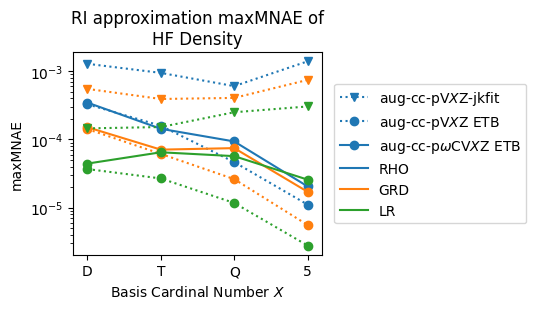

In [22]:
fig, ax = plt.subplots(figsize=(5.5, 3.2))

ax.plot([2, 3, 4, 5], tab_hf_pre_max["RHO"][basis_pvxz],   linestyle=":", color="C0", marker="v")
ax.plot([2, 3, 4, 5], tab_hf_etb_max["RHO"][basis_pvxz],   linestyle=":", color="C0", marker="o")
ax.plot([2, 3, 4, 5], tab_hf_etb_max["RHO"][basis_pwcvxz], linestyle="-", color="C0", marker="o")
ax.plot([2, 3, 4, 5], tab_hf_pre_max["GRD"][basis_pvxz],   linestyle=":", color="C1", marker="v")
ax.plot([2, 3, 4, 5], tab_hf_etb_max["GRD"][basis_pvxz],   linestyle=":", color="C1", marker="o")
ax.plot([2, 3, 4, 5], tab_hf_etb_max["GRD"][basis_pwcvxz], linestyle="-", color="C1", marker="o")
ax.plot([2, 3, 4, 5], tab_hf_pre_max["LR" ][basis_pvxz],   linestyle=":", color="C2", marker="v")
ax.plot([2, 3, 4, 5], tab_hf_etb_max["LR" ][basis_pvxz],   linestyle=":", color="C2", marker="o")
ax.plot([2, 3, 4, 5], tab_hf_etb_max["LR" ][basis_pwcvxz], linestyle="-", color="C2", marker="o")

ax.set_xticks([2, 3, 4, 5])
ax.set_xticklabels(["D", "T", "Q", "5"])
ax.set_xlim(1.8, 5.2)
ax.set_yscale("log")

ax.set_xlabel("Basis Cardinal Number $X$")
ax.set_ylabel("maxMNAE")
ax.set_title("RI approximation maxMNAE of\nHF Density")

l1 = ax.plot([0], [1e-4], linestyle=":", marker="v", color="C0", label="aug-cc-pV$X$Z-jkfit")
l2 = ax.plot([0], [1e-4], linestyle=":", marker="o", color="C0", label="aug-cc-pV$X$Z ETB")
l3 = ax.plot([0], [1e-4], linestyle="-", marker="o", color="C0", label="aug-cc-p$\omega$CV$X$Z ETB")
g1 = ax.plot([0], [1e-4], linestyle="-", color="C0", label="RHO")
g2 = ax.plot([0], [1e-4], linestyle="-", color="C1", label="GRD")
g3 = ax.plot([0], [1e-4], linestyle="-", color="C2", label="LR")
label_lines = [l1, l2, l3, g1, g2, g3]

leg = plt.legend([l[0] for l in label_lines], [l[0].get_label() for l in label_lines], loc="center left", bbox_to_anchor=(1.02, 0.5))

fig.tight_layout()
fig.savefig("../HF-RI-err.pdf", transparent=True, bbox_extra_artists=leg)

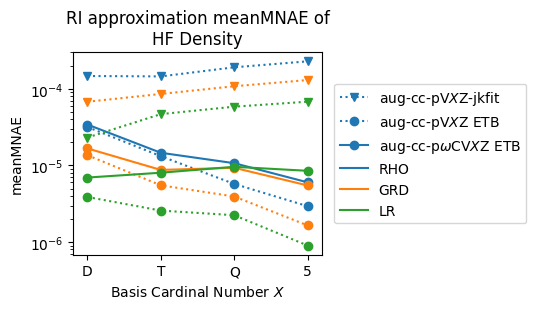

In [23]:
fig, ax = plt.subplots(figsize=(5.5, 3.2))

ax.plot([2, 3, 4, 5], tab_hf_pre_mean["RHO"][basis_pvxz],   linestyle=":", color="C0", marker="v")
ax.plot([2, 3, 4, 5], tab_hf_etb_mean["RHO"][basis_pvxz],   linestyle=":", color="C0", marker="o")
ax.plot([2, 3, 4, 5], tab_hf_etb_mean["RHO"][basis_pwcvxz], linestyle="-", color="C0", marker="o")
ax.plot([2, 3, 4, 5], tab_hf_pre_mean["GRD"][basis_pvxz],   linestyle=":", color="C1", marker="v")
ax.plot([2, 3, 4, 5], tab_hf_etb_mean["GRD"][basis_pvxz],   linestyle=":", color="C1", marker="o")
ax.plot([2, 3, 4, 5], tab_hf_etb_mean["GRD"][basis_pwcvxz], linestyle="-", color="C1", marker="o")
ax.plot([2, 3, 4, 5], tab_hf_pre_mean["LR" ][basis_pvxz],   linestyle=":", color="C2", marker="v")
ax.plot([2, 3, 4, 5], tab_hf_etb_mean["LR" ][basis_pvxz],   linestyle=":", color="C2", marker="o")
ax.plot([2, 3, 4, 5], tab_hf_etb_mean["LR" ][basis_pwcvxz], linestyle="-", color="C2", marker="o")

ax.set_xticks([2, 3, 4, 5])
ax.set_xticklabels(["D", "T", "Q", "5"])
ax.set_xlim(1.8, 5.2)
ax.set_yscale("log")

ax.set_xlabel("Basis Cardinal Number $X$")
ax.set_ylabel("meanMNAE")
ax.set_title("RI approximation meanMNAE of\nHF Density")

l1 = ax.plot([0], [1e-4], linestyle=":", marker="v", color="C0", label="aug-cc-pV$X$Z-jkfit")
l2 = ax.plot([0], [1e-4], linestyle=":", marker="o", color="C0", label="aug-cc-pV$X$Z ETB")
l3 = ax.plot([0], [1e-4], linestyle="-", marker="o", color="C0", label="aug-cc-p$\omega$CV$X$Z ETB")
g1 = ax.plot([0], [1e-4], linestyle="-", color="C0", label="RHO")
g2 = ax.plot([0], [1e-4], linestyle="-", color="C1", label="GRD")
g3 = ax.plot([0], [1e-4], linestyle="-", color="C2", label="LR")
label_lines = [l1, l2, l3, g1, g2, g3]

leg = plt.legend([l[0] for l in label_lines], [l[0].get_label() for l in label_lines], loc="center left", bbox_to_anchor=(1.02, 0.5))

fig.tight_layout()
fig.savefig("../HF-RI-mean.pdf", transparent=True, bbox_extra_artists=leg)

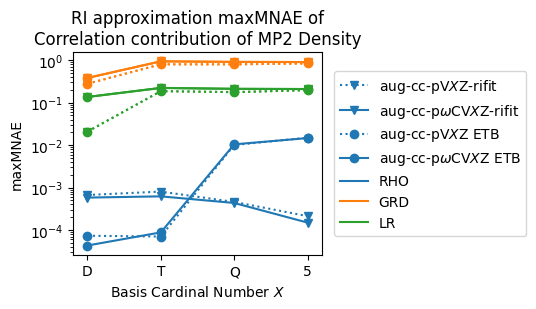

In [24]:
fig, ax = plt.subplots(figsize=(5.5, 3.2))

ax.plot([2, 3, 4, 5], tab_mp2_pre_max["RHO"][basis_pvxz],   linestyle=":", color="C0", marker="v")
ax.plot([2, 3, 4, 5], tab_mp2_etb_max["RHO"][basis_pvxz],   linestyle=":", color="C0", marker="o")
ax.plot([2, 3, 4, 5], tab_mp2_pre_max["RHO"][basis_pwcvxz], linestyle="-", color="C0", marker="v")
ax.plot([2, 3, 4, 5], tab_mp2_etb_max["RHO"][basis_pwcvxz], linestyle="-", color="C0", marker="o")
ax.plot([2, 3, 4, 5], tab_mp2_pre_max["GRD"][basis_pvxz],   linestyle=":", color="C1", marker="v")
ax.plot([2, 3, 4, 5], tab_mp2_etb_max["GRD"][basis_pvxz],   linestyle=":", color="C1", marker="o")
ax.plot([2, 3, 4, 5], tab_mp2_pre_max["GRD"][basis_pwcvxz], linestyle="-", color="C1", marker="v")
ax.plot([2, 3, 4, 5], tab_mp2_etb_max["GRD"][basis_pwcvxz], linestyle="-", color="C1", marker="o")
ax.plot([2, 3, 4, 5], tab_mp2_pre_max["LR" ][basis_pvxz],   linestyle=":", color="C2", marker="v")
ax.plot([2, 3, 4, 5], tab_mp2_etb_max["LR" ][basis_pvxz],   linestyle=":", color="C2", marker="o")
ax.plot([2, 3, 4, 5], tab_mp2_pre_max["LR" ][basis_pwcvxz], linestyle="-", color="C2", marker="v")
ax.plot([2, 3, 4, 5], tab_mp2_etb_max["LR" ][basis_pwcvxz], linestyle="-", color="C2", marker="o")

ax.set_xticks([2, 3, 4, 5])
ax.set_xticklabels(["D", "T", "Q", "5"])
ax.set_xlim(1.8, 5.2)
ax.set_yscale("log")

ax.set_xlabel("Basis Cardinal Number $X$")
ax.set_ylabel("maxMNAE")
ax.set_title("RI approximation maxMNAE of\nCorrelation contribution of MP2 Density")

l1 = ax.plot([0], [1e-4], linestyle=":", marker="v", color="C0", label="aug-cc-pV$X$Z-rifit")
l2 = ax.plot([0], [1e-4], linestyle="-", marker="v", color="C0", label="aug-cc-p$\omega$CV$X$Z-rifit")
l3 = ax.plot([0], [1e-4], linestyle=":", marker="o", color="C0", label="aug-cc-pV$X$Z ETB")
l4 = ax.plot([0], [1e-4], linestyle="-", marker="o", color="C0", label="aug-cc-p$\omega$CV$X$Z ETB")
g1 = ax.plot([0], [1e-4], linestyle="-", color="C0", label="RHO")
g2 = ax.plot([0], [1e-4], linestyle="-", color="C1", label="GRD")
g3 = ax.plot([0], [1e-4], linestyle="-", color="C2", label="LR")
label_lines = [l1, l2, l3, l4, g1, g2, g3]

leg = plt.legend([l[0] for l in label_lines], [l[0].get_label() for l in label_lines], loc="center left", bbox_to_anchor=(1.02, 0.5))

fig.tight_layout()
fig.savefig("../MP2-RI-err.pdf", transparent=True, bbox_extra_artists=leg)

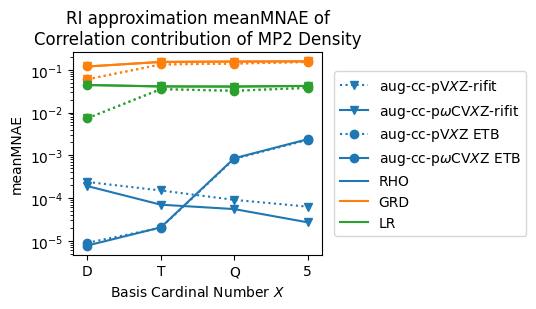

In [25]:
fig, ax = plt.subplots(figsize=(5.5, 3.2))

ax.plot([2, 3, 4, 5], tab_mp2_pre_mean["RHO"][basis_pvxz],   linestyle=":", color="C0", marker="v")
ax.plot([2, 3, 4, 5], tab_mp2_etb_mean["RHO"][basis_pvxz],   linestyle=":", color="C0", marker="o")
ax.plot([2, 3, 4, 5], tab_mp2_pre_mean["RHO"][basis_pwcvxz], linestyle="-", color="C0", marker="v")
ax.plot([2, 3, 4, 5], tab_mp2_etb_mean["RHO"][basis_pwcvxz], linestyle="-", color="C0", marker="o")
ax.plot([2, 3, 4, 5], tab_mp2_pre_mean["GRD"][basis_pvxz],   linestyle=":", color="C1", marker="v")
ax.plot([2, 3, 4, 5], tab_mp2_etb_mean["GRD"][basis_pvxz],   linestyle=":", color="C1", marker="o")
ax.plot([2, 3, 4, 5], tab_mp2_pre_mean["GRD"][basis_pwcvxz], linestyle="-", color="C1", marker="v")
ax.plot([2, 3, 4, 5], tab_mp2_etb_mean["GRD"][basis_pwcvxz], linestyle="-", color="C1", marker="o")
ax.plot([2, 3, 4, 5], tab_mp2_pre_mean["LR" ][basis_pvxz],   linestyle=":", color="C2", marker="v")
ax.plot([2, 3, 4, 5], tab_mp2_etb_mean["LR" ][basis_pvxz],   linestyle=":", color="C2", marker="o")
ax.plot([2, 3, 4, 5], tab_mp2_pre_mean["LR" ][basis_pwcvxz], linestyle="-", color="C2", marker="v")
ax.plot([2, 3, 4, 5], tab_mp2_etb_mean["LR" ][basis_pwcvxz], linestyle="-", color="C2", marker="o")

ax.set_xticks([2, 3, 4, 5])
ax.set_xticklabels(["D", "T", "Q", "5"])
ax.set_xlim(1.8, 5.2)
ax.set_yscale("log")

ax.set_xlabel("Basis Cardinal Number $X$")
ax.set_ylabel("meanMNAE")
ax.set_title("RI approximation meanMNAE of\nCorrelation contribution of MP2 Density")

l1 = ax.plot([0], [1e-4], linestyle=":", marker="v", color="C0", label="aug-cc-pV$X$Z-rifit")
l2 = ax.plot([0], [1e-4], linestyle="-", marker="v", color="C0", label="aug-cc-p$\omega$CV$X$Z-rifit")
l3 = ax.plot([0], [1e-4], linestyle=":", marker="o", color="C0", label="aug-cc-pV$X$Z ETB")
l4 = ax.plot([0], [1e-4], linestyle="-", marker="o", color="C0", label="aug-cc-p$\omega$CV$X$Z ETB")
g1 = ax.plot([0], [1e-4], linestyle="-", color="C0", label="RHO")
g2 = ax.plot([0], [1e-4], linestyle="-", color="C1", label="GRD")
g3 = ax.plot([0], [1e-4], linestyle="-", color="C2", label="LR")
label_lines = [l1, l2, l3, l4, g1, g2, g3]

leg = plt.legend([l[0] for l in label_lines], [l[0].get_label() for l in label_lines], loc="center left", bbox_to_anchor=(1.02, 0.5))

fig.tight_layout()
fig.savefig("../MP2-RI-mean.pdf", transparent=True, bbox_extra_artists=leg)

# Energy Part

In [26]:
atom_2e = ["B+3", "C+4", "N+5", "O+6", "F+7", "Ne+8"]
atom_4e = ["B+1", "C+2", "N+3", "O+4", "F+5", "Ne+6"]

In [30]:
%%time
with h5py.File("etot.h5", "r") as f:
    eng_dict = h5group_to_dict(f)

CPU times: user 71.9 ms, sys: 81.9 ms, total: 154 ms
Wall time: 298 ms


In [31]:
%%time
with h5py.File("etot-ri.h5", "r") as f:
    eng_ri_dict = h5group_to_dict(f)

CPU times: user 32.7 ms, sys: 32.6 ms, total: 65.3 ms
Wall time: 168 ms


## Parse data

In [32]:
hf_conv = data.nist.HARTREE2EV * (
    + pd.DataFrame(eng_dict["HF"]).loc[atom_2e][basis_pvxz + basis_pwcvxz]
    - np.array(pd.DataFrame(eng_dict["HF"]).loc[atom_4e][basis_pvxz + basis_pwcvxz]))
hf_conv

,aug-cc-pvdz,aug-cc-pvtz,aug-cc-pvqz,aug-cc-pv5z,aug-cc-pwcvdz,aug-cc-pwcvtz,aug-cc-pwcvqz,aug-cc-pwcv5z
B+3,61.214265,61.257201,61.261400,61.261694,61.234656,61.258708,61.261329,61.261698
C+4,109.980534,110.127029,110.130072,110.131146,110.070388,110.127178,110.129864,110.131205
N+5,172.363909,172.673797,172.681014,172.684585,172.577491,172.676636,172.680531,172.684691
O+6,248.352679,248.855197,248.878718,248.886763,248.723822,248.870860,248.877898,248.886897
F+7,337.895713,338.645189,338.706518,338.720020,338.485326,338.692192,338.705479,338.720200
Ne+8,440.975142,442.034729,442.154281,442.175944,441.849348,442.131549,442.153271,442.176219


In [33]:
hf_pre = data.nist.HARTREE2EV * (
    + pd.DataFrame(eng_ri_dict["HF-RI"]).loc[atom_2e][basis_pvxz]
    - np.array(pd.DataFrame(eng_ri_dict["HF-RI"]).loc[atom_4e][basis_pvxz]))
hf_pre

,aug-cc-pvdz,aug-cc-pvtz,aug-cc-pvqz,aug-cc-pv5z
B+3,61.214264,61.257213,61.261404,61.261699
C+4,109.980511,110.127023,110.130046,110.131126
N+5,172.363901,172.673825,172.681041,172.684603
O+6,248.352705,248.855247,248.878795,248.886816
F+7,337.895758,338.645262,338.706638,338.720102
Ne+8,440.975231,442.034828,442.154461,442.176066


In [34]:
hf_etb = data.nist.HARTREE2EV * (
    + pd.DataFrame(eng_ri_dict["HF-ETB"]).loc[atom_2e][basis_pvxz + basis_pwcvxz]
    - np.array(pd.DataFrame(eng_ri_dict["HF-ETB"]).loc[atom_4e][basis_pvxz + basis_pwcvxz]))
hf_etb

,aug-cc-pvdz,aug-cc-pvtz,aug-cc-pvqz,aug-cc-pv5z,aug-cc-pwcvdz,aug-cc-pwcvtz,aug-cc-pwcvqz,aug-cc-pwcv5z
B+3,61.214266,61.257201,61.261400,61.261695,61.234657,61.258709,61.261329,61.261698
C+4,109.980538,110.127029,110.130072,110.131146,110.070392,110.127178,110.129864,110.131206
N+5,172.363917,172.673797,172.681014,172.684586,172.577500,172.676635,172.680531,172.684692
O+6,248.352689,248.855197,248.878718,248.886763,248.723833,248.870860,248.877898,248.886897
F+7,337.895723,338.645189,338.706519,338.720020,338.485338,338.692193,338.705480,338.720200
Ne+8,440.975155,442.034729,442.154283,442.175944,441.849363,442.131551,442.153273,442.176220


In [35]:
mp2_conv = data.nist.HARTREE2EV * (
    + pd.DataFrame(eng_dict["MP2"]).loc[atom_2e][basis_pvxz + basis_pwcvxz]
    - np.array(pd.DataFrame(eng_dict["MP2"]).loc[atom_4e][basis_pvxz + basis_pwcvxz]))
mp2_conv

,aug-cc-pvdz,aug-cc-pvtz,aug-cc-pvqz,aug-cc-pv5z,aug-cc-pwcvdz,aug-cc-pwcvtz,aug-cc-pwcvqz,aug-cc-pwcv5z
B+3,62.119395,62.273538,62.376681,62.415543,62.231835,62.405195,62.455105,62.472280
C+4,111.079568,111.345257,111.469163,111.513932,111.277704,111.504720,111.562895,111.583588
N+5,173.649861,174.078046,174.224878,174.277927,173.981660,174.264074,174.330188,174.355836
O+6,249.817690,250.424804,250.610350,250.674253,250.312008,250.651591,250.729952,250.762269
F+7,339.535858,340.382773,340.621834,340.694363,340.249829,340.661918,340.751986,340.791054
Ne+8,442.786964,443.940932,444.249851,444.333516,443.784198,444.286401,444.388219,444.436157


In [36]:
mp2_pre = data.nist.HARTREE2EV * (
    + pd.DataFrame(eng_ri_dict["MP2-RI"]).loc[atom_2e][basis_pvxz + basis_pwcvxz]
    - np.array(pd.DataFrame(eng_ri_dict["MP2-RI"]).loc[atom_4e][basis_pvxz + basis_pwcvxz]))
mp2_pre

,aug-cc-pvdz,aug-cc-pvtz,aug-cc-pvqz,aug-cc-pv5z,aug-cc-pwcvdz,aug-cc-pwcvtz,aug-cc-pwcvqz,aug-cc-pwcv5z
B+3,62.119286,62.273502,62.376652,62.415523,62.231740,62.405183,62.455093,62.472274
C+4,111.079504,111.345217,111.469132,111.513902,111.277644,111.504706,111.562880,111.583578
N+5,173.649668,174.077969,174.224824,174.277897,173.981492,174.264049,174.330165,174.355827
O+6,249.817430,250.424698,250.610274,250.674215,250.311802,250.651567,250.729927,250.762258
F+7,339.535539,340.382651,340.621792,340.694318,340.249597,340.661893,340.751972,340.791039
Ne+8,442.786708,443.940759,444.249794,444.333473,443.784054,444.286372,444.388203,444.436142


In [37]:
mp2_etb = data.nist.HARTREE2EV * (
    + pd.DataFrame(eng_ri_dict["MP2-ETB"]).loc[atom_2e][basis_pvxz + basis_pwcvxz]
    - np.array(pd.DataFrame(eng_ri_dict["MP2-ETB"]).loc[atom_4e][basis_pvxz + basis_pwcvxz]))
mp2_etb

,aug-cc-pvdz,aug-cc-pvtz,aug-cc-pvqz,aug-cc-pv5z,aug-cc-pwcvdz,aug-cc-pwcvtz,aug-cc-pwcvqz,aug-cc-pwcv5z
B+3,62.119388,62.273517,62.376619,62.410636,62.231826,62.405174,62.455072,62.467352
C+4,111.079557,111.345237,111.469119,111.509175,111.277691,111.504698,111.562865,111.578801
N+5,173.649848,174.078021,174.224825,174.273367,173.981644,174.264047,174.330137,174.351246
O+6,249.817683,250.424782,250.610296,250.669918,250.311997,250.651568,250.729886,250.757907
F+7,339.535851,340.382751,340.621777,340.690117,340.249818,340.661895,340.751912,340.786776
Ne+8,442.786953,443.940905,444.249796,444.329326,443.784184,444.286374,444.388141,444.431939


## Plot curve

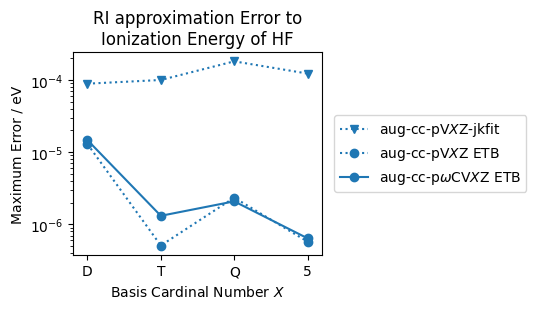

In [38]:
fig, ax = plt.subplots(figsize=(5.5, 3.2))

ax.plot([2, 3, 4, 5], (hf_pre - hf_conv)[basis_pvxz].abs().max(),   linestyle=":", color="C0", marker="v")
ax.plot([2, 3, 4, 5], (hf_etb - hf_conv)[basis_pvxz].abs().max(),   linestyle=":", color="C0", marker="o")
ax.plot([2, 3, 4, 5], (hf_etb - hf_conv)[basis_pwcvxz].abs().max(), linestyle="-", color="C0", marker="o")

ax.set_xticks([2, 3, 4, 5])
ax.set_xticklabels(["D", "T", "Q", "5"])
ax.set_xlim(1.8, 5.2)
ax.set_yscale("log")

ax.set_xlabel("Basis Cardinal Number $X$")
ax.set_ylabel("Maximum Error / eV")
ax.set_title("RI approximation Error to\nIonization Energy of HF")

l1 = ax.plot([0], [1e-4], linestyle=":", marker="v", color="C0", label="aug-cc-pV$X$Z-jkfit")
l2 = ax.plot([0], [1e-4], linestyle=":", marker="o", color="C0", label="aug-cc-pV$X$Z ETB")
l3 = ax.plot([0], [1e-4], linestyle="-", marker="o", color="C0", label="aug-cc-p$\omega$CV$X$Z ETB")
label_lines = [l1, l2, l3]

leg = plt.legend([l[0] for l in label_lines], [l[0].get_label() for l in label_lines], loc="center left", bbox_to_anchor=(1.02, 0.5))

fig.tight_layout()
fig.savefig("../HF-RI-eng.pdf", transparent=True, bbox_extra_artists=leg)

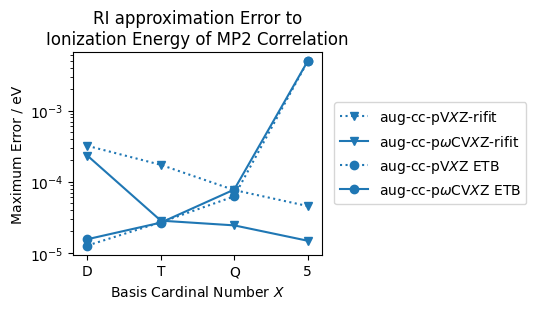

In [39]:
fig, ax = plt.subplots(figsize=(5.5, 3.2))

ax.plot([2, 3, 4, 5], (mp2_pre - mp2_conv)[basis_pvxz].abs().max(),   linestyle=":", color="C0", marker="v")
ax.plot([2, 3, 4, 5], (mp2_pre - mp2_conv)[basis_pwcvxz].abs().max(), linestyle="-", color="C0", marker="v")
ax.plot([2, 3, 4, 5], (mp2_etb - mp2_conv)[basis_pvxz].abs().max(),   linestyle=":", color="C0", marker="o")
ax.plot([2, 3, 4, 5], (mp2_etb - mp2_conv)[basis_pwcvxz].abs().max(), linestyle="-", color="C0", marker="o")

ax.set_xticks([2, 3, 4, 5])
ax.set_xticklabels(["D", "T", "Q", "5"])
ax.set_xlim(1.8, 5.2)
ax.set_yscale("log")

ax.set_xlabel("Basis Cardinal Number $X$")
ax.set_ylabel("Maximum Error / eV")
ax.set_title("RI approximation Error to\nIonization Energy of MP2 Correlation")

l1 = ax.plot([0], [1e-4], linestyle=":", marker="v", color="C0", label="aug-cc-pV$X$Z-rifit")
l2 = ax.plot([0], [1e-4], linestyle="-", marker="v", color="C0", label="aug-cc-p$\omega$CV$X$Z-rifit")
l3 = ax.plot([0], [1e-4], linestyle=":", marker="o", color="C0", label="aug-cc-pV$X$Z ETB")
l4 = ax.plot([0], [1e-4], linestyle="-", marker="o", color="C0", label="aug-cc-p$\omega$CV$X$Z ETB")
label_lines = [l1, l2, l3, l4]

leg = plt.legend([l[0] for l in label_lines], [l[0].get_label() for l in label_lines], loc="center left", bbox_to_anchor=(1.02, 0.5))

fig.tight_layout()
fig.savefig("../MP2-RI-eng.pdf", transparent=True, bbox_extra_artists=leg)

In [40]:
(mp2_etb - mp2_conv)[basis_pwcvxz]

,aug-cc-pwcvdz,aug-cc-pwcvtz,aug-cc-pwcvqz,aug-cc-pwcv5z
B+3,-0.000009,-0.000021,-0.000033,-0.004928
C+4,-0.000013,-0.000022,-0.000029,-0.004787
N+5,-0.000016,-0.000027,-0.000051,-0.004589
O+6,-0.000011,-0.000023,-0.000066,-0.004362
F+7,-0.000011,-0.000023,-0.000074,-0.004277
Ne+8,-0.000014,-0.000027,-0.000078,-0.004218
